#Parkinson Disease Prediction

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('parkinson_disease.csv')
df.shape
df.describe()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,...,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,99.000000,0.547739,0.743928,0.699567,0.492398,322.043551,320.762144,0.006429,0.000401,0.002411,...,25.183601,22.392119,18.892698,14.272159,12.491529,12.721852,15.086392,14.951157,31.871954,0.765101
std,57.493799,0.498133,0.168592,0.071655,0.137237,101.516710,101.621289,0.001861,0.000759,0.002667,...,41.649278,32.284514,25.690977,20.480072,18.036664,16.554110,15.870459,14.497775,34.502323,0.424292
min,0.000000,0.000000,0.041551,0.545320,0.154300,2.000000,1.000000,0.002107,0.000011,0.000210,...,1.520400,1.531700,1.582900,1.747200,1.834900,1.628700,1.861700,1.955900,2.364000,0.000000
25%,49.000000,0.000000,0.758720,0.642560,0.388520,250.000000,249.000000,0.005085,0.000052,0.001020,...,2.395825,3.452800,3.335425,3.067775,2.919300,3.108125,3.673825,3.768175,3.887600,1.000000
50%,99.000000,1.000000,0.809730,0.696460,0.491230,310.000000,309.000000,0.006200,0.000079,0.001590,...,5.457850,7.097000,6.093150,4.861750,4.254700,4.788450,6.913600,7.661650,10.179150,1.000000
75%,149.000000,1.000000,0.833470,0.757560,0.590890,378.000000,377.000000,0.007639,0.000174,0.002630,...,23.158175,27.080400,22.783375,14.079275,11.640600,12.973375,22.834075,23.033800,62.162125,1.000000
max,198.000000,1.000000,0.907660,0.852640,0.871230,907.000000,905.000000,0.012966,0.003483,0.027750,...,212.223400,158.979100,121.256900,102.207000,85.571700,73.241700,62.007300,57.544300,156.423700,1.000000


Data Cleaning

In [ ]:
df = df.groupby('id').mean().reset_index()
df.drop('id' , axis=1 , inplace = True)

These many features only indicate that they have been derived from one another or we can say that the correlation between them is quite high. In the below code block a function has been implemented which can remove the highly correlated features except for the target column.

In [ ]:
columns = list(df.columns)
for col in columns:
  if col == 'class':
    continue
  filteredCol = [col]
  for col1 in df.columns:
    if((col == col1) | (col == 'class')):
      continue
    val = df[col].corr(df[col1])
    if val > 0.7:
      # If the correlation between the two
      # features is more than 0.7 remove
      columns.remove(col1)
      continue
    else:
      filteredCol.append(col1)
  df = df[filteredCol]
df.shape

(199, 280)

So, from a feature space of 755 columns, we have reduced it to a feature space of 287 columns. But still, it is too high as the number of features is still more than the number of examples or data points. Reason behind this statement is the same as that behind the curse of dimensionality problem as the feature space grows the number of examples required to generalize on the dataset becomes difficult and the model’s performance decreases.

#So, let’s reduce the feature space up to 30 by using the chi-square test.

In [ ]:
X = df.drop('class', axis = 1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2 , k = 30)
selector.fit(X_norm, df['class'])
filteredCol = selector.get_support()
filteredData = X.loc[:, filteredCol]
filteredData['class'] = df['class']
df= filteredData
df.shape

<ipython-input-6-0651d63b0285>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredData['class'] = df['class']


(199, 31)

<function matplotlib.pyplot.show(close=None, block=None)>

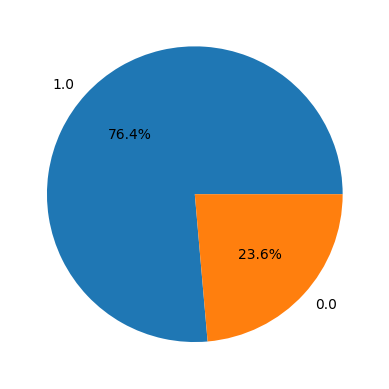

In [ ]:
x = df['class'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct='%1.1f%%')
plt.show

 We see that data is imbalanced

#Model training

In [ ]:
X = df.drop('class',axis=1)
y = df['class']

X_train , X_test , y_train , y_test = train_test_split(X,y, test_size=0.2,
                                                      random_state=10)
X_train.shape , X_test.shape

((159, 30), (40, 30))

Solving the data imbalance problem by using the over-sampling method on the minority class.

In [ ]:
ros = RandomOverSampler(sampling_strategy='minority',
                        random_state=0)
X , y = ros.fit_resample(X_train, y_train)
X.shape , y.shape

((238, 30), (238,))

The dataset has been already normalized in the data cleaning step we can directly train some state-of-the-art machine learning models and compare them which fit better with our data.

In [ ]:
from sklearn.metrics import roc_auc_score as ras
models = [LogisticRegression(), XGBClassifier(),SVC(kernel='rbf',probability=True)]

for i in range(len(models)):
  models[i].fit(X,y)
  print(f'{models[i]}:')

  predictions = models[i].predict_proba(X)[:, 1]
  print('Accuracy :',ras(y, predictions))

  val_predicitions = models[i].predict_proba(X_test)[:, 1]
  print('Validation Accuracy :',ras(y_test, val_predicitions))

  print()



LogisticRegression():
Accuracy : 0.8612386130922958
Validation Accuracy : 0.7922077922077922

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...):
Accuracy : 1.0
Validation Accuracy : 0.7748917748917749

SVC(probability=True):
Accuracy : 0.7152743450321305
Validation Accuracy : 0.8571428571428

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


From the above accuracies, we can say that Logistic Regression and SVC() classifier perform better on the validation data with less difference between the validation and training data. Let’s plot the confusion matrix as well for the validation data using the Logistic Regression model.

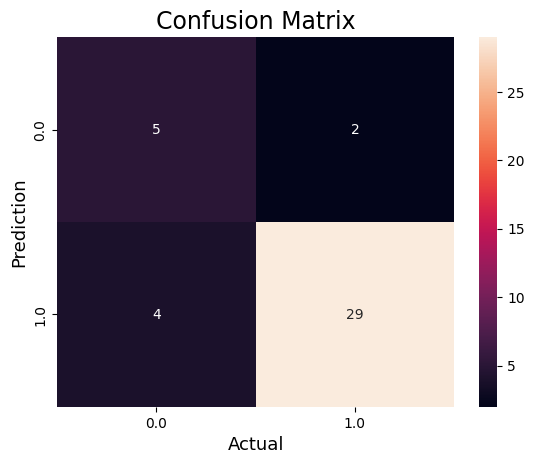

In [ ]:
cm = confusion_matrix(y_test, models[0].predict(X_test))
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['0.0','1.0'],
            yticklabels=['0.0','1.0'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
print(metrics.classification_report
      (y_test, models[0].predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.56      0.71      0.63         7
         1.0       0.94      0.88      0.91        33

    accuracy                           0.85        40
   macro avg       0.75      0.80      0.77        40
weighted avg       0.87      0.85      0.86        40



#Conclusion
The machine learning model we have created is around 75% to 80% accurate. The disease for which there are no diagnostics methods machine learning models are able to predict whether the person has Parkinson’s disease or not.